## For Next Time

- Add a date column for the regression.
- Goal is to essentially have poll company + date = next_poll spread 
- Look at white papers to see schedule for date. 
- Fit the model everyday, generate a prediction for every poll, and see if it comes out the next day. 
- Real-time predictions with errors. 
- Just do Joe-Biden Trump, print out predictions for most common polls; maybe make a .txt file output and then compare. 
- Real Clear Polling for that as the data source 
- Sentiment Analysis + Trending search terms
- Plot polling aggregation by day accounting for some sort of bias by the polling companies. 
- Use some sort of standard time series model using all of the polling data. 
- Gaussian process, GAM, splines, time series, polynomial regression, for a more flexible model. 

Poll_outcome = poll company + time_since +....?

Keep thinking about google trends somehow

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

# Suppress a specific warning
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
base_url = "https://www.realclearpolling.com/polls/"
sample_url = "president/general/2024/trump-vs-biden"
url = base_url + sample_url

In [3]:
# Create a webdriver instance and get the page source
driver = webdriver.Chrome()
driver.get(url)

# Allow time for dynamic content to load (you may need to adjust the sleep duration)
time.sleep(3)

# Get the page source after dynamic content has loaded
html_content = driver.page_source

# Close the webdriver
driver.quit()

# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, 'html5lib')

# Now you can extract the table data using the same approach as before
table = soup.find_all('table')

if len(table)==2:
    table = table[1]
else:
    table = table[0]

table_data = []
for row in table.find_all('tr'):
    row_data = [cell.text.strip() for cell in row.find_all(['td','th'])]
    table_data.append(row_data)
df = pd.DataFrame(table_data[1:], columns=table_data[0])
df.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread
0,RCP Average,3/25 - 4/17,—,—,44.6,44.2,Trump+0.4
1,Emerson,4/16 - 4/17,1308 RV,2.6,46,43,Trump+3
2,Daily Kos/Civiqs,4/13 - 4/16,1161 RV,3.0,45,44,Trump+1
3,Yahoo News,4/11 - 4/15,1171 RV,—,44,44,Tie
4,NY Times/Siena,4/7 - 4/11,1059 LV,3.5,47,46,Trump+1


In [4]:
#Convert table data to a dataframe
#We remove the first row since this is RCP summary data that we don't want to use

current_year = str(datetime.now().year)
prev_year = str(datetime.now().year-1)



df["Difference"] = df["Trump (R)"].astype(float) - df["Biden (D)"].astype(float)
df["Type of Voter"] = df["sample"].str.split(" ").str[1]
df["Sample Size"] = pd.to_numeric(df["sample"].str.split(" ").str[0], errors="coerce").fillna(0).astype(int)
#We need to add the year to the date to make it a datetime object
#We need to make sure the year we add is the year the poll was taken, not necessarily the current year
df["End Date"] = df["date"].str.split("-").str[1] 
df["Poll Month"] = df["date"].str.split("-").str[1].str.split("/").str[0]
df["Poll Month"] = df["Poll Month"].astype(int)
first_dec = df[df["Poll Month"]==12].index[0]
df["Year"] = [current_year]*first_dec + [prev_year]*(len(df)-first_dec)
df["End Date"] = df["End Date"] + "/" + df["Year"]
df["End Date"] = np.array(pd.to_datetime(df["End Date"], format="mixed"))
df = df[df["Type of Voter"].isin(["RV", "LV"])]
df["Biden (D)"] = df["Biden (D)"].astype(float)
df["Trump (R)"] = df["Trump (R)"].astype(float)
df["Days Since 01-01-23"] = (df["End Date"] - pd.to_datetime("01-01-23")).dt.days
df.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
1,Emerson,4/16 - 4/17,1308 RV,2.6,46.0,43.0,Trump+3,3.0,RV,1308,2024-04-17,4,2024,472
2,Daily Kos/Civiqs,4/13 - 4/16,1161 RV,3.0,45.0,44.0,Trump+1,1.0,RV,1161,2024-04-16,4,2024,471
3,Yahoo News,4/11 - 4/15,1171 RV,—,44.0,44.0,Tie,0.0,RV,1171,2024-04-15,4,2024,470
4,NY Times/Siena,4/7 - 4/11,1059 LV,3.5,47.0,46.0,Trump+1,1.0,LV,1059,2024-04-11,4,2024,466
5,Morning Consult,4/5 - 4/7,6236 RV,1.0,44.0,43.0,Trump+1,1.0,RV,6236,2024-04-07,4,2024,462


In [5]:
#Create a time series plot of the candidates' polling numbers using plotly
fig = px.scatter(df, x="End Date", y=["Trump (R)", "Biden (D)"], title="Trump vs. Biden Polling Numbers",  color_discrete_map={"Trump (R)":"red", "Biden (D)":"blue"})
fig.show()

In [6]:
ndf = pd.get_dummies(df[["pollster"]], drop_first=True)
ndf["Days Since 01-01-23"] = df["Days Since 01-01-23"]
ndf.head()

,pollster_CBS News,pollster_CNBC,pollster_CNN,pollster_Daily Kos/Civiqs,pollster_Data for Progress (D)**,pollster_Economist/YouGov,pollster_Emerson,pollster_FOX News,pollster_Federalist/Susquehanna,pollster_Forbes/HarrisX,...,pollster_Reuters/Ipsos,pollster_SurveyUSA,pollster_Susquehanna,pollster_The Messenger/HarrisX,pollster_Trafalgar Group (R),pollster_USA Today/Suffolk,pollster_Wall Street Journal,pollster_Yahoo News,pollster_Yahoo News**,Days Since 01-01-23
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,472
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,471
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,470
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,466
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,462


In [7]:
# Build a categorical regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = ndf
y = df[["Difference"]]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [8]:
from datetime import datetime

today_date = datetime.now().strftime("%m-%d-%Y") #Get today's date
days_since_2023 = (pd.to_datetime(today_date) - pd.to_datetime("01-01-2023")).days
cols = ndf.columns[:-1]
diag = np.diag(np.ones(len(cols)))

tomorrow_df = pd.DataFrame(diag, columns=cols)
tomorrow_df["Days Since 01-01-23"] = days_since_2023 + 1 #Add 1 to the days since 2023 to make it the next day
tomorrow_df.head()



,pollster_CBS News,pollster_CNBC,pollster_CNN,pollster_Daily Kos/Civiqs,pollster_Data for Progress (D)**,pollster_Economist/YouGov,pollster_Emerson,pollster_FOX News,pollster_Federalist/Susquehanna,pollster_Forbes/HarrisX,...,pollster_Reuters/Ipsos,pollster_SurveyUSA,pollster_Susquehanna,pollster_The Messenger/HarrisX,pollster_Trafalgar Group (R),pollster_USA Today/Suffolk,pollster_Wall Street Journal,pollster_Yahoo News,pollster_Yahoo News**,Days Since 01-01-23
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475


In [9]:
#Format the prediction into a readable text
tomorrow_pred = model.predict(tomorrow_df)
#Make a dataframe 
tomorrow_pred_df = pd.DataFrame(tomorrow_pred, columns=["Linear Predicted Difference"])
tomorrow_pred_df.set_index(cols, inplace=True)
tomorrow_pred_df.head()

,Linear Predicted Difference
pollster_CBS News,3.066080
pollster_CNBC,1.134931
pollster_CNN,3.680279
pollster_Daily Kos/Civiqs,0.174286
pollster_Data for Progress (D)**,-1.215379


In [10]:
import xgboost

y = df["Difference"]

#Create an XGBoost model
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.1)
model.fit(X, y)

#Make predictions
y_pred = model.predict(tomorrow_df)

tomorrow_pred_df["XGBoost Predicted Difference"] = y_pred

#Maybe we can try to backtest our model to see how well it would have predicted the past
def make_test_df(date):
    """
    Create a test DataFrame for a given date.

    Parameters:
    date (str): The date in the format "mm-dd-yyyy".

    Returns:
    pandas.DataFrame: The test DataFrame with columns representing the features and "Days Since 01-01-23" column.
    """
    days_since_2023 = (pd.to_datetime(date) - pd.to_datetime("01-01-2023")).days
    cols = ndf.columns[:-1]
    diag = np.diag(np.ones(len(cols)))
    test_df = pd.DataFrame(diag, columns=cols)
    test_df["Days Since 01-01-23"] = days_since_2023
    return test_df

def make_model(date):
    """
    Create a model for a given date.

    Parameters:
    date (str): The date in the format "mm-dd-yyyy".

    Returns:
    xgboost.XGBRegressor: The trained XGBoost model.
    """
    days_since_2023 = (pd.to_datetime(date) - pd.to_datetime("01-01-2023")).days
    X = ndf[ndf["Days Since 01-01-23"] < days_since_2023]
    y = df["Difference"][ndf["Days Since 01-01-23"] < days_since_2023]
    model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    model.fit(X, y)
    return model

#Make a list of dates to test
dates = pd.date_range(start="01-01-2024", end=today_date, freq="D")
dates = dates.strftime("%m-%d-%Y")

test_dfs = [make_test_df(date) for date in dates]
models = [make_model(date) for date in dates]


preds = [] 
for i in range(len(dates)):
    preds.append(models[i].predict(test_dfs[i]))
   

#Make a list of predictions
# preds = [list(model.predict(test_df).flatten()) for test_df in test_dfs]

data = pd.DataFrame(data = preds, columns =cols)
data["Date"] = dates
data.head()

,pollster_CBS News,pollster_CNBC,pollster_CNN,pollster_Daily Kos/Civiqs,pollster_Data for Progress (D)**,pollster_Economist/YouGov,pollster_Emerson,pollster_FOX News,pollster_Federalist/Susquehanna,pollster_Forbes/HarrisX,...,pollster_Reuters/Ipsos,pollster_SurveyUSA,pollster_Susquehanna,pollster_The Messenger/HarrisX,pollster_Trafalgar Group (R),pollster_USA Today/Suffolk,pollster_Wall Street Journal,pollster_Yahoo News,pollster_Yahoo News**,Date
0,1.466776,1.189989,2.304852,1.189989,-0.834021,0.260507,1.311735,2.681681,-1.086431,1.189989,...,1.189989,1.189989,-8.110139,4.528813,4.144851,0.728629,-0.285265,0.481346,-3.35852,01-01-2024
1,1.020887,0.811542,1.997587,0.811542,-0.859700,-0.200276,1.071186,2.576796,-1.489589,0.811542,...,0.811542,0.811542,-8.635641,4.187644,3.888368,0.544059,-0.472101,0.197180,-3.63482,01-02-2024
2,1.010513,0.726187,1.883407,0.726187,-0.885726,-0.025236,0.726187,2.349622,-1.817577,0.726187,...,0.726187,0.726187,-9.008847,4.020505,3.673298,0.484887,-1.015601,0.244972,-3.85607,01-03-2024
3,1.010513,0.726187,1.883407,0.726187,-0.885726,-0.025236,0.726187,2.349622,-1.817577,0.726187,...,0.726187,0.726187,-9.008847,4.020505,3.673298,0.484887,-1.015601,0.244972,-3.85607,01-04-2024
4,1.010513,0.726187,1.883407,0.726187,-0.885726,-0.025236,0.726187,2.349622,-1.817577,0.726187,...,0.726187,0.726187,-9.008847,4.020505,3.673298,0.484887,-1.015601,0.244972,-3.85607,01-05-2024


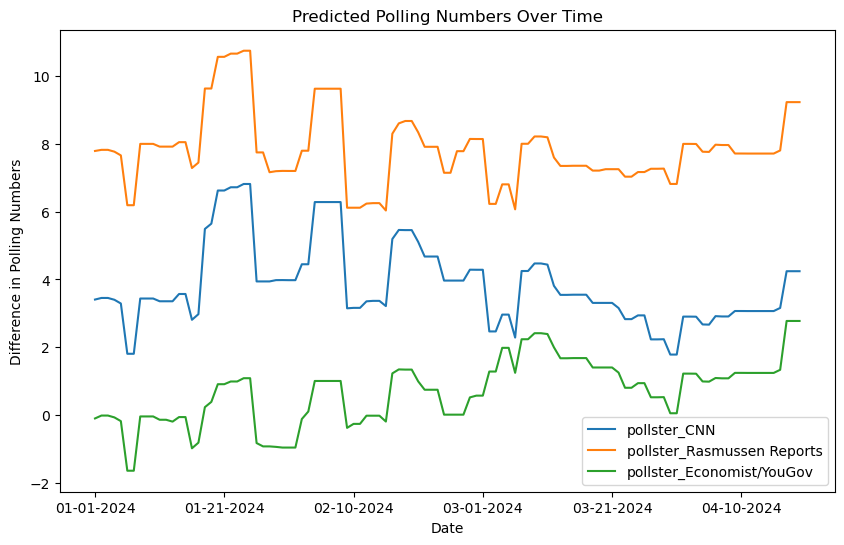

In [11]:
#Use today's model to make predictions on past data

today_model = model
preds = [] 
for i in range(len(dates)):
    preds.append(model.predict(test_dfs[i]))

#Convert the predictions to a DataFrame
data = pd.DataFrame(data = preds, columns =cols)
data["Date"]  = dates

#Plot CNN, Ramussen, and YouGov's predictions as a time series
polls = ["pollster_CNN", "pollster_Rasmussen Reports", "pollster_Economist/YouGov"]
polls_df = data[["Date"] + polls]
polls_df.set_index("Date", inplace=True)
polls_df.plot(figsize=(10,6))
plt.title("Predicted Polling Numbers Over Time")
plt.xlabel("Date")
plt.ylabel("Difference in Polling Numbers")
plt.show()

#ax.plot(data["Date"], data["Rasmussen Reports"], label="Rasmussen Reports")
#ax.plot(data["Date"], data["YouGov"], label="YouGov")

In [12]:
tomorrow_pred_df.head()

,Linear Predicted Difference,XGBoost Predicted Difference
pollster_CBS News,3.066080,3.704570
pollster_CNBC,1.134931,2.528169
pollster_CNN,3.680279,4.243119
pollster_Daily Kos/Civiqs,0.174286,2.597367
pollster_Data for Progress (D)**,-1.215379,1.560444


In [13]:
# Make an excel file where each sheet is that day's prediction
#Add the sheet to an existing file

path_name = "Datasets/Predictions.xlsx"

# Open the existing file in write mode and add the new sheet
try:
    with pd.ExcelWriter(path_name, engine = 'openpyxl', mode = 'a') as writer:
        tomorrow_pred_df.to_excel(writer, sheet_name=today_date)
except:
    print("File was already added in a past run-through")


In [14]:
#Look specifically at the polls released last, we will want to compare these to yesterday's predictions

today_df = df[df["End Date"].iloc[1] == df["End Date"]].copy()
today_df["pollster"] = "pollster_" + today_df["pollster"] 
today_df.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
2,pollster_Daily Kos/Civiqs,4/13 - 4/16,1161 RV,3.0,45.0,44.0,Trump+1,1.0,RV,1161,2024-04-16,4,2024,471


In [15]:
#Check to see if any of the polls from today are in yesterday's predictions
#If so, we will compare the predictions to the actual results

yesterday_date = (pd.to_datetime(today_date) - pd.Timedelta(days=1)).strftime("%m-%d-%Y")
try:
    yesterday_df = pd.read_excel("Datasets/Predictions.xlsx", sheet_name=yesterday_date)
except:
    yesterday_df = pd.read_excel("Datasets/Predictions.xlsx", sheet_name=-1)
yesterday_df.rename(columns={"Unnamed: 0":"Pollster"}, inplace=True)
yesterday_df.head()

,Pollster,Linear Predicted Difference,XGBoost Predicted Difference
0,pollster_CBS News,3.066080,3.704570
1,pollster_CNBC,1.134931,2.528169
2,pollster_CNN,3.680279,4.243119
3,pollster_Daily Kos/Civiqs,0.174286,2.597367
4,pollster_Data for Progress (D)**,-1.215379,1.560444


In [16]:
#Subset the predictions to only include the polls from today
values = today_df["pollster"].values
today_pred = yesterday_df[yesterday_df["Pollster"].isin(values)].copy()
print(today_pred)
today_pred["Actual Difference"] = today_df["Difference"].values
today_pred

                    Pollster  Linear Predicted Difference  \
3  pollster_Daily Kos/Civiqs                     0.174286   

   XGBoost Predicted Difference  
3                      2.597367  


,Pollster,Linear Predicted Difference,XGBoost Predicted Difference,Actual Difference
3,pollster_Daily Kos/Civiqs,0.174286,2.597367,1.0


In [17]:
#Calculate the root mean squared error
if len(today_pred) == 0:
    rmse = "No polls from today were in yesterday's predictions"
else:
    rmse = np.sqrt(mean_squared_error(today_pred["Actual Difference"], today_pred["XGBoost Predicted Difference"]))
print("RMSE IS: " , rmse)

RMSE IS:  1.597367286682129


In [18]:
#Maybe plot our predictions overtime to see how they compare to the actual results

#We will need to read in the predictions file and then plot the predictions over time

#Read in the predictions file
predictions = pd.ExcelFile("Datasets/Predictions.xlsx")
sheets = predictions.sheet_names

#Create a dataframe to store the predictions
predictions_df = pd.DataFrame()

#Iterate through the sheets and append the data to the dataframe
for sheet in sheets:
    data_frame = pd.read_excel("Datasets/Predictions.xlsx", sheet_name=sheet)
    data_frame["Date"] = sheet
    predictions_df = pd.concat([predictions_df,data])

predictions_df.rename(columns={"Unnamed: 0":"Pollster"}, inplace=True)
predictions_df

,pollster_CBS News,pollster_CNBC,pollster_CNN,pollster_Daily Kos/Civiqs,pollster_Data for Progress (D)**,pollster_Economist/YouGov,pollster_Emerson,pollster_FOX News,pollster_Federalist/Susquehanna,pollster_Forbes/HarrisX,...,pollster_Reuters/Ipsos,pollster_SurveyUSA,pollster_Susquehanna,pollster_The Messenger/HarrisX,pollster_Trafalgar Group (R),pollster_USA Today/Suffolk,pollster_Wall Street Journal,pollster_Yahoo News,pollster_Yahoo News**,Date
0,2.081913,1.289211,3.407693,-0.390555,-1.997600,-0.097075,3.025853,2.975865,-2.164939,2.979722,...,0.487337,1.297179,-7.381651,4.446974,5.355603,0.979324,-2.060297,-0.077575,-2.885974,01-01-2024
1,2.129038,1.336336,3.454818,-0.343430,-1.950475,-0.011704,1.196775,2.992771,-2.117814,3.026847,...,0.528841,1.344304,-7.334525,4.494101,5.402729,1.026449,-2.014816,-0.030450,-2.838848,01-02-2024
2,2.129038,1.336336,3.454818,-0.343430,-1.950475,-0.011704,1.196775,2.992771,-2.117814,3.026847,...,0.528841,1.344304,-7.334525,4.494101,5.402729,1.026449,-2.014816,-0.030450,-2.838848,01-03-2024
3,2.075522,1.282820,3.401302,-0.396946,-2.001989,-0.066407,1.143259,2.939255,-2.171330,2.973331,...,0.475325,1.290788,-7.388040,4.440586,5.349214,0.972933,-2.068332,-0.066164,-2.892364,01-04-2024
4,1.965629,1.172928,3.291410,-0.506838,-2.111880,-0.176299,1.033367,2.829363,-2.281222,2.863439,...,0.365433,1.180896,-7.460711,4.330694,5.239322,0.863041,-2.178223,-0.147199,-3.002256,01-05-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2.490571,0.838918,3.068317,0.909409,-0.128894,1.244840,1.344640,4.668488,-2.616816,0.331892,...,-3.450517,0.851341,-7.956253,4.261427,5.043963,0.479381,0.510327,0.006436,-3.317917,04-15-2024
106,2.582616,0.930963,3.160362,1.000164,-0.036849,1.336885,1.436685,4.759650,-2.524771,0.422675,...,-3.409677,0.943386,-7.864208,4.353473,5.136010,0.571426,0.602372,0.098481,-3.225872,04-16-2024
107,3.704570,2.528169,4.243119,2.597367,1.560444,2.776388,2.993475,5.465870,-0.901924,2.100933,...,-1.768217,2.540591,-6.256113,5.906416,6.111333,2.168632,2.199578,1.718206,-1.628668,04-17-2024
108,3.704570,2.528169,4.243119,2.597367,1.560444,2.776388,2.993475,5.465870,-0.901924,2.100933,...,-1.768217,2.540591,-6.256113,5.906416,6.111333,2.168632,2.199578,1.718206,-1.628668,04-18-2024


## Today's Notes

- Go back in time to retrain the model on what polls would have existed at the time. 
- Switch from linear regression towards a better model. (Polls show larger changes, but linear regression really cannot change that much within a day)
- Add a column for google trend data somehow? Would require thinking
- Add a column from the betting lines/averages?
- How can we incorporate 538's "bias" feature? Maybe in some sort of weighting. 
- Let's do cubic spline. 
- Take the average offset of the polls to make some sort of aggregations. 
- Take a weighted average of bias...?
- Can also do a set of orthogonal polynomials...but only if time. 

Compare the plot to realclearpolling's data overtime. 

Additionally, if time we can work on just calculating the spread between Biden and Trump when there are more than two candidates on the ballot, and compare it to the spread when it's just the two of them.

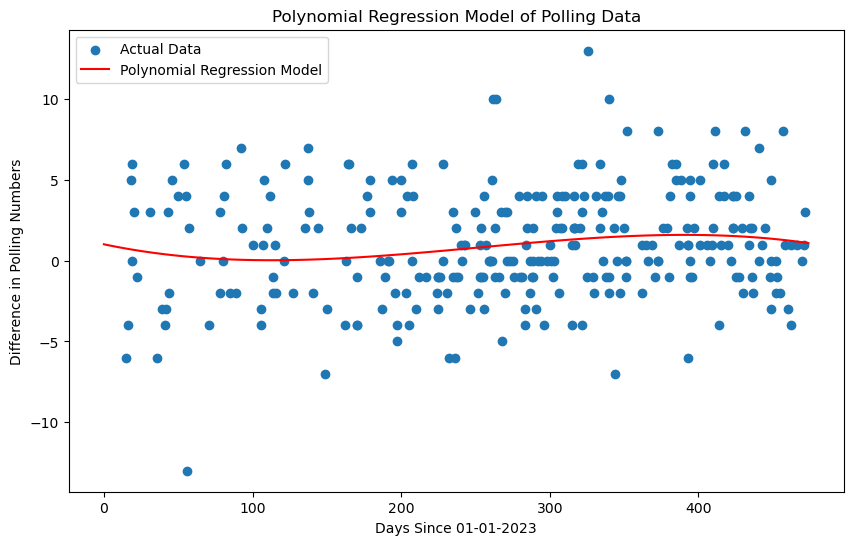

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Create a polynomial regression model
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X["Days Since 01-01-23"].values.reshape(-1,1), df["Difference"].values)    

#Make predictions using the polynomial model
x = np.linspace(0, days_since_2023, 100)
y = model.predict(x.reshape(-1,1))


#Plot the polynomial regression model
plt.figure(figsize=(10,6))
plt.scatter(df["Days Since 01-01-23"], df["Difference"], label="Actual Data")
plt.plot(x, y, color="red", label="Polynomial Regression Model")
plt.title("Polynomial Regression Model of Polling Data")
plt.xlabel("Days Since 01-01-2023")
plt.ylabel("Difference in Polling Numbers")
plt.legend()

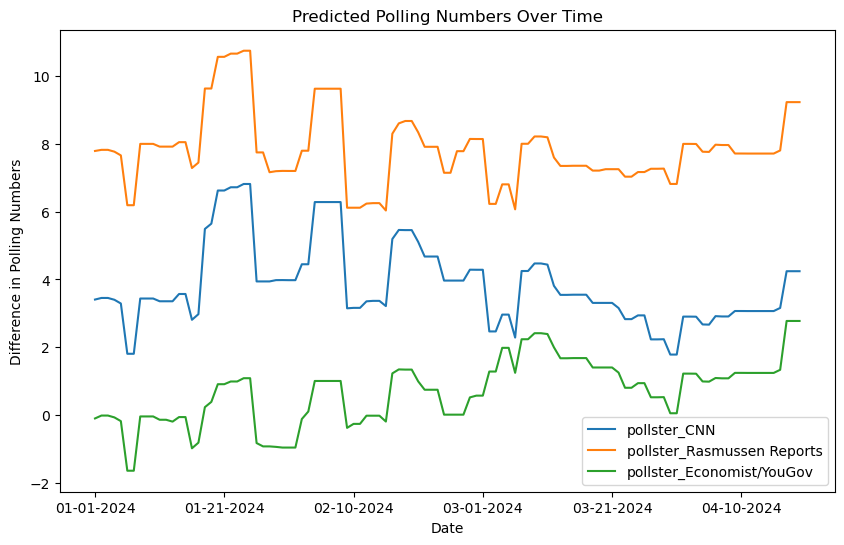

In [20]:
#Let's choose a few polls and plot the predictions over time

polls = ["pollster_CNN", "pollster_Rasmussen Reports", "pollster_Economist/YouGov"]
polls_df = data[["Date"] + polls]
polls_df.set_index("Date", inplace=True)
polls_df.plot(figsize=(10,6))
plt.title("Predicted Polling Numbers Over Time")
plt.xlabel("Date")
plt.ylabel("Difference in Polling Numbers")
plt.show()

/var/folders/h7/ctfkf21x7jd7ykb9j1km5blr0000gp/T/ipykernel_7121/344900662.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



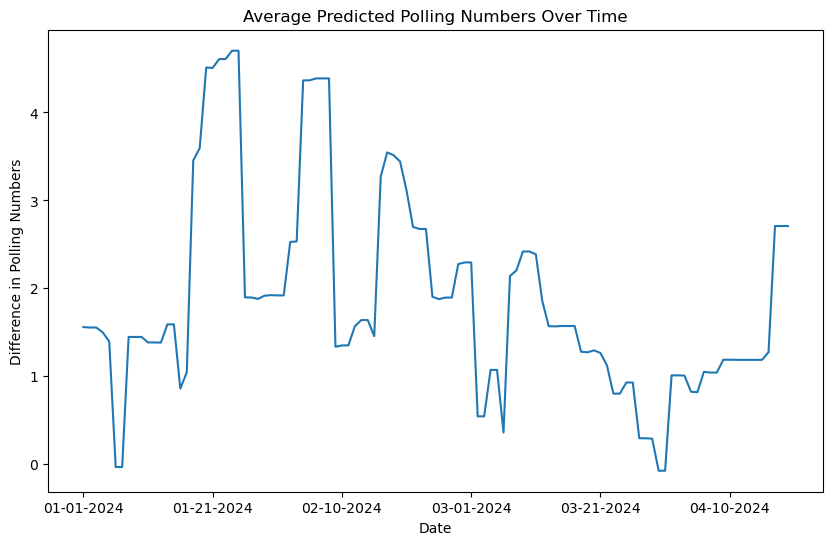

In [21]:
#Take the average of the predictions for each day to get a sense of the overall trend

polls_df["Average"] = data[cols].mean(axis=1).values
polls_df["Average"].plot(figsize=(10,6))
plt.title("Average Predicted Polling Numbers Over Time")
plt.xlabel("Date")
plt.ylabel("Difference in Polling Numbers")

#Add the true polling numbers to the plot
plt.show()

In [22]:
# Goal is to backcast our linear regression model over the course of 2024

def subset_data(df, date):
    """
    Subset the data to only include polls up to a given date.
    """
    return df[df["End Date"] < date]

def make_model(df,date):
    ndf = subset_data(df, date)
    y = ndf["Difference"]
    X = pd.get_dummies(ndf[["pollster"]], drop_first=True)
    X["Days Since 01-01-23"] = ndf["Days Since 01-01-23"]
    model = LinearRegression()
    model.fit(X, y)
    return model

model = make_model(df,"2024-01-09")

def make_prediction_df(df, date):
    model = make_model(df, date)
    data = subset_data(df,date)
    #Find which polls were taken on date
    pollsters = np.unique(df[df["End Date"]==date]["pollster"])
    pollsters = ["pollster_" + pollster for pollster in pollsters]
    data = pd.get_dummies(data, drop_first=True)
    subset = subset_data(data, date)
    poll_companies = [col for col in subset.columns if "pollster" in col]
    subset = subset[["Days Since 01-01-23"]+ poll_companies]
    prediction_df = pd.DataFrame(columns = list(subset.columns),data=np.zeros((len(pollsters),len(subset.columns))))
    prediction_df["Days Since 01-01-23"] = max(subset["Days Since 01-01-23"])+1
    #Ensure that each categorical variable gets a 1 in the correct column
    nvecs = []
    for i in range(len(pollsters)):
        vec = np.zeros(len(pollsters))
        vec[i] = 1
        nvecs.append(vec)
    for i in range(len(pollsters)):
        prediction_df[pollsters[i]] = nvecs[i]
    model_features = model.feature_names_in_
    prediction_df = prediction_df[model_features]
    return prediction_df

example = make_prediction_df(df,"2024-01-09")

def make_prediction(model, prediction_df):
    pred = model.predict(prediction_df)
    return pred 

def score_model(model,df, date):
    model = make_model(df, date)
    y_pred_df = make_prediction_df(df, date)
    y_pred = model.predict(y_pred_df)
    y_true = df[df["End Date"] == date]["Difference"]
    if len(y_true) == 0:
        return None
    return mean_squared_error(y_true, y_pred)




In [23]:
# Days in df where 
end_dates = df[df["End Date"]>= "2024-01-01"]["End Date"]

mse_list = []
for date in end_dates:
    model = make_model(df,date)
    score = score_model(model,df,date)
    mse_list.append(score)
print(np.mean(np.sqrt(mse_list)))

2.3254208870793747
